<a href="https://colab.research.google.com/github/Atreyee2001/Handwritten_English_Word_Recognition/blob/main/word_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q kaggle 

In [ ]:
from google.colab import files
files.upload() 

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"suparnasadhu","key":"acca0ffafa03d51eaf9552e1a7df6d77"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json 

In [ ]:
! kaggle datasets list 

ref                                                         title                                              size  lastUpdated          downloadCount  
----------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
gpreda/reddit-vaccine-myths                                 Reddit Vaccine Myths                              237KB  2021-12-12 11:59:54          17957  
crowww/a-large-scale-fish-dataset                           A Large Scale Fish Dataset                          3GB  2021-04-28 17:03:01          10695  
imsparsh/musicnet-dataset                                   MusicNet Dataset                                   22GB  2021-02-18 14:12:19           5332  
dhruvildave/wikibooks-dataset                               Wikibooks Dataset                                   2GB  2021-10-22 10:48:21           3838  
promptcloud/careerbuilder-job-listing-2020                  Careerbuilder Jo

In [ ]:
! kaggle datasets download -d nibinv23/iam-handwriting-word-database

100% 1.10G/1.10G [00:12<00:00, 83.5MB/s]
100% 1.10G/1.10G [00:12<00:00, 94.8MB/s]


In [ ]:
! unzip iam-handwriting-word-database.zip

Streaming output truncated to the last 5000 lines.
  inflating: iam_words/words/p06/p06-069/p06-069-03-07.png  
  inflating: iam_words/words/p06/p06-069/p06-069-03-08.png  
  inflating: iam_words/words/p06/p06-069/p06-069-03-09.png  
  inflating: iam_words/words/p06/p06-069/p06-069-03-10.png  
  inflating: iam_words/words/p06/p06-069/p06-069-04-00.png  
  inflating: iam_words/words/p06/p06-069/p06-069-04-01.png  
  inflating: iam_words/words/p06/p06-069/p06-069-04-02.png  
  inflating: iam_words/words/p06/p06-069/p06-069-04-03.png  
  inflating: iam_words/words/p06/p06-069/p06-069-04-04.png  
  inflating: iam_words/words/p06/p06-069/p06-069-04-05.png  
  inflating: iam_words/words/p06/p06-069/p06-069-04-06.png  
  inflating: iam_words/words/p06/p06-069/p06-069-05-00.png  
  inflating: iam_words/words/p06/p06-069/p06-069-05-01.png  
  inflating: iam_words/words/p06/p06-069/p06-069-05-02.png  
  inflating: iam_words/words/p06/p06-069/p06-069-05-03.png  
  inflating: iam_words/words/p06/p

In [ ]:
import numpy as np
import cv2
import os
import pandas as pd
import string
import matplotlib.pyplot as plt

from keras.preprocessing.sequence import pad_sequences

from keras.layers import Dense, LSTM, Reshape, BatchNormalization, Input, Conv2D, MaxPool2D, Lambda, Bidirectional
from keras.models import Model
from keras.activations import relu, sigmoid, softmax
import keras.backend as K

from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from PIL import Image

import tensorflow as tf

#ignore warnings in the output
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [ ]:
images = []
labels = []

RECORDS_COUNT = 30000

In [ ]:
with open('/content/iam_words/words.txt') as f:
    contents = f.readlines()[18:22539]

lines = [line.strip() for line in contents] 
lines[1004]

'a01-020-04-03 ok 176 873 1646 135 97 VB give'

In [ ]:
def process_image(img):
    """
    Converts image to shape (32, 128, 1) & normalize
    """
    w, h = img.shape
    
#     _, img = cv2.threshold(img, 
#                            128, 
#                            255, 
#                            cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    
    # Aspect Ratio Calculation
    new_w = 32
    new_h = int(h * (new_w / w))
    img = cv2.resize(img, (new_h, new_w))
    w, h = img.shape
    
    img = img.astype('float32')
    
    # Converts each to (32, 128, 1)
    if w < 32:
        add_zeros = np.full((32-w, h), 255)
        img = np.concatenate((img, add_zeros))
        w, h = img.shape
    
    if h < 128:
        add_zeros = np.full((w, 128-h), 255)
        img = np.concatenate((img, add_zeros), axis=1)
        w, h = img.shape
        
    if h > 128 or w > 32:
        dim = (128,32)
        img = cv2.resize(img, dim)
    
    img = cv2.subtract(255, img)
    
    img = np.expand_dims(img, axis=2)
    
    # Normalize 
    img = img / 255
    
    return img

In [ ]:
max_label_len = 0

char_list = "!\"#&'()*+,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz" 

# string.ascii_letters + string.digits (Chars & Digits)
# or 
# "!\"#&'()*+,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz"

print(char_list, len(char_list))

def encode_to_labels(txt):
    # encoding each output word into digits
    dig_lst = []
    for index, chara in enumerate(txt):
        dig_lst.append(char_list.index(chara))
        
    return dig_lst

!"#&'()*+,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz 78


In [ ]:
train_images = []
train_labels = []
train_input_length = []
train_label_length = []
train_original_text = []

valid_images = []
valid_labels = []
valid_input_length = []
valid_label_length = []
valid_original_text = []

inputs_length = []
labels_length = []

In [ ]:
for index, line in enumerate(lines):
    splits = line.split(' ')
    status= splits[1]

    if status == 'ok':
        word_id = splits[0]
        word = "".join(splits[8:])
        
        splits_id = word_id.split('-')
        filepath = './iam_words/words/{}/{}-{}/{}.png'.format(splits_id[0], 
                                                  splits_id[0], 
                                                  splits_id[1], 
                                                  word_id)
      
        # process image
        img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
        try:
            img = process_image(img)
        except:
            continue
            
        # process label
        try:
            label = encode_to_labels(word)
        except:
            continue
        
        if index % 10 == 0:
            valid_images.append(img)
            valid_labels.append(label)
            valid_input_length.append(31)
            valid_label_length.append(len(word))
            valid_original_text.append(word)
        else:
            train_images.append(img)
            train_labels.append(label)
            train_input_length.append(31)
            train_label_length.append(len(word))
            train_original_text.append(word)
        
        if len(word) > max_label_len:
            max_label_len = len(word)
    
    if index >= RECORDS_COUNT:
        break



In [ ]:
train_padded_label = pad_sequences(train_labels, 
                             maxlen=max_label_len, 
                             padding='post',
                             value=len(char_list))

valid_padded_label = pad_sequences(valid_labels, 
                             maxlen=max_label_len, 
                             padding='post',
                             value=len(char_list))

In [ ]:
train_labels[3101]

[70, 67, 56, 65, 55, 60, 65, 58]

In [ ]:
train_padded_label[3101]

array([70, 67, 56, 65, 55, 60, 65, 58, 78, 78, 78, 78, 78, 78, 78, 78, 78],
      dtype=int32)

In [ ]:
train_padded_label.shape, valid_padded_label.shape

((18074, 17), (2007, 17))

In [ ]:
train_images = np.asarray(train_images)
train_input_length = np.asarray(train_input_length)
train_label_length = np.asarray(train_label_length)

valid_images = np.asarray(valid_images)
valid_input_length = np.asarray(valid_input_length)
valid_label_length = np.asarray(valid_label_length)

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras import backend as tf_keras_backend
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten

tf_keras_backend.set_image_data_format('channels_last')
tf_keras_backend.image_data_format()

'channels_last'

In [ ]:
def Model1():
    # input with shape of height=32 and width=128 
    inputs = Input(shape=(32,128,1))

    # convolution layer with kernel size (3,3)
    conv_1 = Conv2D(64, (3,3), activation = 'relu', padding='same')(inputs)
    # poolig layer with kernel size (2,2)
    pool_1 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_1)

    conv_2 = Conv2D(128, (3,3), activation = 'relu', padding='same')(pool_1)
    pool_2 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_2)

    conv_3 = Conv2D(256, (3,3), activation = 'relu', padding='same')(pool_2)

    conv_4 = Conv2D(256, (3,3), activation = 'relu', padding='same')(conv_3)
    # poolig layer with kernel size (2,1)
    pool_4 = MaxPool2D(pool_size=(2, 1))(conv_4)

    conv_5 = Conv2D(512, (3,3), activation = 'relu', padding='same')(pool_4)
    # Batch normalization layer
    batch_norm_5 = BatchNormalization()(conv_5)

    conv_6 = Conv2D(512, (3,3), activation = 'relu', padding='same')(batch_norm_5)
    batch_norm_6 = BatchNormalization()(conv_6)
    pool_6 = MaxPool2D(pool_size=(2, 1))(batch_norm_6)

    conv_7 = Conv2D(512, (2,2), activation = 'relu')(pool_6)

    squeezed = Lambda(lambda x: K.squeeze(x, 1))(conv_7)

    # bidirectional LSTM layers with units=128
    blstm_1 = Bidirectional(LSTM(256, return_sequences=True, dropout = 0.24))(squeezed)
    blstm_2 = Bidirectional(LSTM(256, return_sequences=True, dropout = 0.24))(blstm_1)

    outputs = Dense(len(char_list)+1, activation = 'softmax')(blstm_2)

    # model to be used at test time
    act_model = Model(inputs, outputs)
    
    return act_model,outputs,inputs

In [ ]:
act_model,outputs,inputs=Model1()

In [ ]:
act_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 128, 1)]      0         
                                                                 
 conv2d (Conv2D)             (None, 32, 128, 64)       640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 64, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 64, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 32, 128)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 32, 256)        295168

In [ ]:
the_labels = Input(name='the_labels', shape=[max_label_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([outputs, the_labels, input_length, label_length])

#model to be used at training time
model = Model(inputs=[inputs, the_labels, input_length, label_length], outputs=loss_out)

In [ ]:
batch_size = 5
epochs = 30
e = str(epochs)
optimizer_name = 'sgd'

In [ ]:
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer = optimizer_name, metrics=['accuracy'])

filepath="{}o-{}r-{}e-{}t-{}v.hdf5".format(optimizer_name,
                                          str(RECORDS_COUNT),
                                          str(epochs),
                                          str(train_images.shape[0]),
                                          str(valid_images.shape[0]))

checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto')
callbacks_list = [checkpoint]

In [ ]:
history = model.fit(x=[train_images, train_padded_label, train_input_length, train_label_length],
                    y=np.zeros(len(train_images)),
                    batch_size=batch_size, 
                    epochs=epochs, 
                    validation_data=([valid_images, valid_padded_label, valid_input_length, valid_label_length], [np.zeros(len(valid_images))]),
                    verbose=1,
                    callbacks=callbacks_list)

Epoch 1/30
3615/3615 [==============================] - ETA: 0s - loss: 13.5996 - accuracy: 0.0221
Epoch 00001: val_accuracy improved from -inf to 0.06079, saving model to sgdo-30000r-30e-18074t-2007v.hdf5
3615/3615 [==============================] - 345s 88ms/step - loss: 13.5996 - accuracy: 0.0221 - val_loss: 11.7015 - val_accuracy: 0.0608
Epoch 2/30
3615/3615 [==============================] - ETA: 0s - loss: 9.7620 - accuracy: 0.0881
Epoch 00002: val_accuracy did not improve from 0.06079
3615/3615 [==============================] - 289s 80ms/step - loss: 9.7620 - accuracy: 0.0881 - val_loss: 10.8698 - val_accuracy: 0.0608
Epoch 3/30
3615/3615 [==============================] - ETA: 0s - loss: 5.9584 - accuracy: 0.1955
Epoch 00003: val_accuracy improved from 0.06079 to 0.18585, saving model to sgdo-30000r-30e-18074t-2007v.hdf5
3615/3615 [==============================] - 291s 81ms/step - loss: 5.9584 - accuracy: 0.1955 - val_loss: 6.6500 - val_accuracy: 0.1858
Epoch 4/30
3615/3615 [

In [ ]:
model.save(filepath='./model3.h5', overwrite=False, include_optimizer=True) 

In [ ]:
! pip install python-Levenshtein==0.12.0

     |████████████████████████████████| 48 kB 2.6 MB/s 
Reason for being yanked: Insecure, upgrade to 0.12.1
  Created wheel for python-Levenshtein: filename=python_Levenshtein-0.12.0-cp37-cp37m-linux_x86_64.whl size=145902 sha256=f728b0c185c6872f31f58eca43b747ad92909590add17d951590b9c91d17752c
  Stored in directory: /root/.cache/pip/wheels/f0/9b/13/49c281164c37be18343230d3cd0fca29efb23a493351db0009
Successfully built python-Levenshtein


In [ ]:
filepath='/content/sgdo-30000r-30e-18074t-2007v.hdf5'
# load the saved best model weights
act_model.load_weights(filepath)

# predict outputs on validation images
prediction = act_model.predict(valid_images)
 
# use CTC decoder
decoded = K.ctc_decode(prediction, 
                       input_length=np.ones(prediction.shape[0]) * prediction.shape[1],
                       greedy=True)[0][0]
out = K.get_value(decoded)

import Levenshtein as lv

total_jaro = 0

# see the results
for i, x in enumerate(out):
    letters=''
    for p in x:
        if int(p) != -1:
            letters+=char_list[int(p)]
    total_jaro+=lv.jaro(letters, valid_original_text[i])
  
print('jaro :', total_jaro/len(out))

jaro : 0.9448056361048399


original_text =   .
predicted text = .

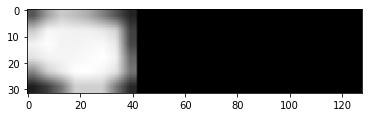



original_text =   of
predicted text = of

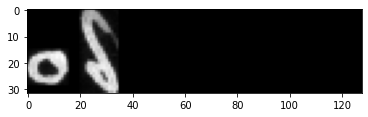



original_text =   Macmillan
predicted text = Macmillan

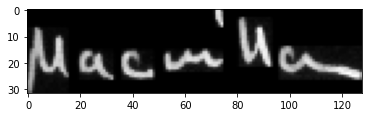



original_text =   ,
predicted text = ,

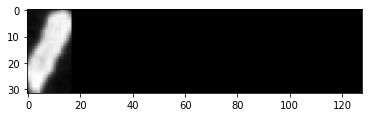

In [ ]:
i=1000
j=1004
prediction = act_model.predict(valid_images[i:j])
 
# use CTC decoder
decoded = K.ctc_decode(prediction,   
                       input_length=np.ones(prediction.shape[0]) * prediction.shape[1],
                       greedy=True)[0][0]

out = K.get_value(decoded)

# see the results
for _, x in enumerate(out):
    
    print("original_text =  ", valid_original_text[i])
    print("predicted text = ", end = '')
    for p in x:
        if int(p) != -1:
            print(char_list[int(p)], end = '')
    plt.imshow(valid_images[i].reshape(32,128), cmap=plt.cm.gray)
    plt.show()
    i+=1
    print('\n')
    

original_text =   a
predicted text = a

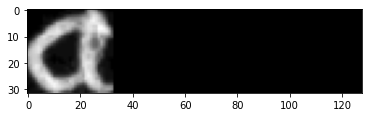



original_text =   placid
predicted text = placid

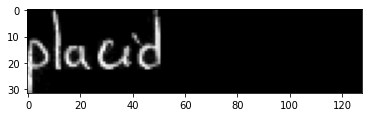



original_text =   wild
predicted text = wild

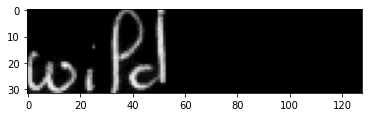



original_text =   ?
predicted text = ?

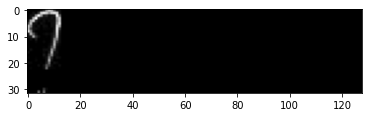



original_text =   one
predicted text = one

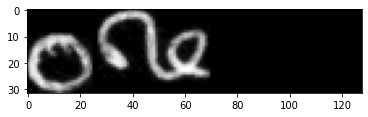



original_text =   extra
predicted text = exctie

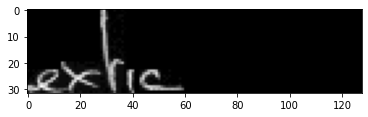



original_text =   on
predicted text = on

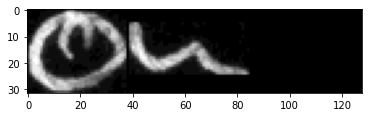



original_text =   open
predicted text = eger

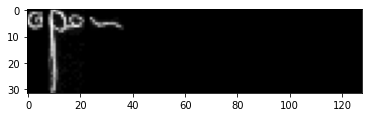



original_text =   find
predicted text = fond

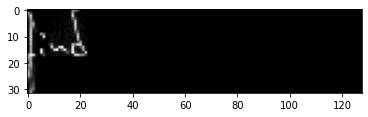



original_text =   18.1
predicted text = 18.1

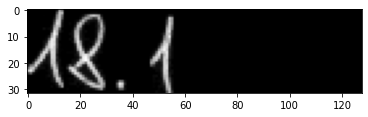



original_text =   social
predicted text = social

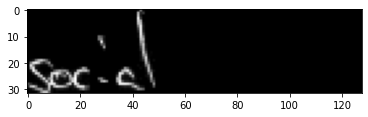



original_text =   There
predicted text = There

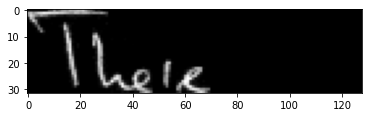



original_text =   a
predicted text = a

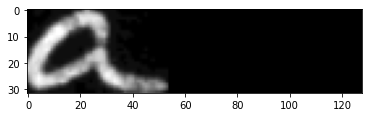



original_text =   MARCIA
predicted text = MARCSA

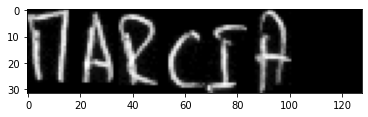



original_text =   ,
predicted text = ,

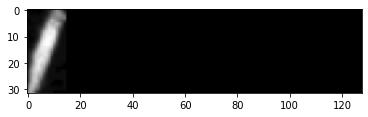



original_text =   gardening
predicted text = apiduning

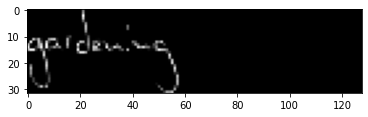



original_text =   books
predicted text = books

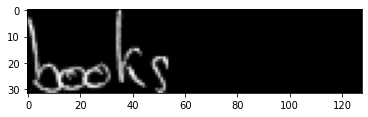



original_text =   ?
predicted text = ?

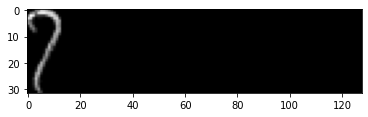



original_text =   folly
predicted text = foly

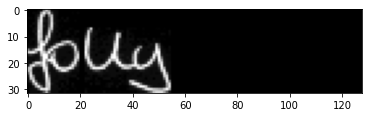



original_text =   peaceful
predicted text = peaceful

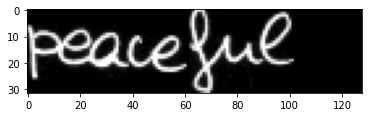



original_text =   Federal
predicted text = Federal

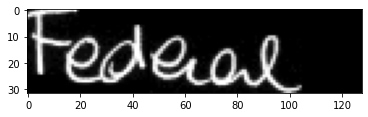



original_text =   Mr.
predicted text = Mr.

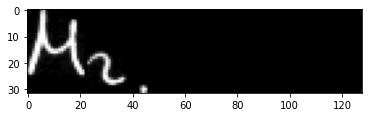



original_text =   .
predicted text = .

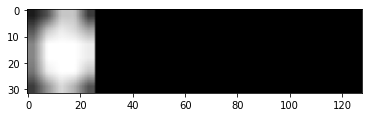



original_text =   rushed
predicted text = sushed

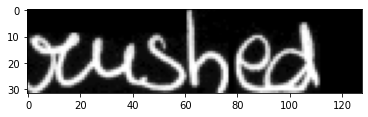



original_text =   were
predicted text = were

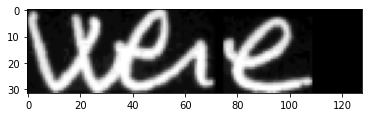



original_text =   Government
predicted text = Gaermment

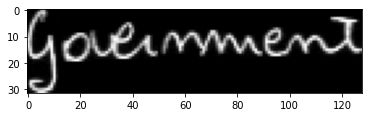



original_text =   Africans
predicted text = Africans

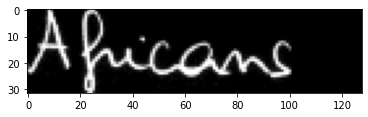



original_text =   ,
predicted text = ,

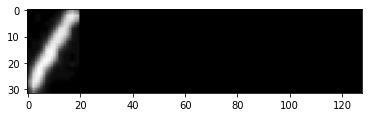



original_text =   -
predicted text = .

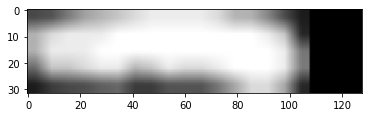



original_text =   wonder
predicted text = wonder

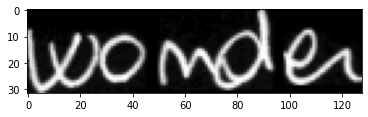



original_text =   Government
predicted text = Government

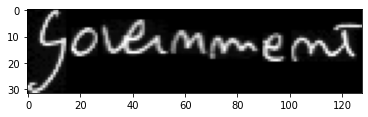



original_text =   in
predicted text = in

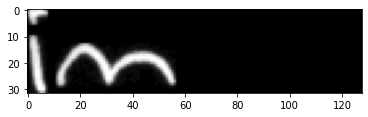



original_text =   politicians
predicted text = politicians

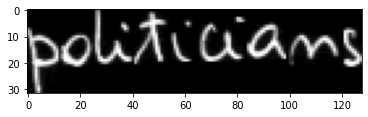



original_text =   modify
predicted text = modify

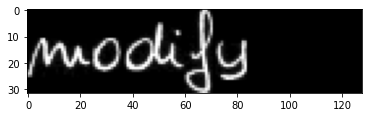



original_text =   ,
predicted text = ,

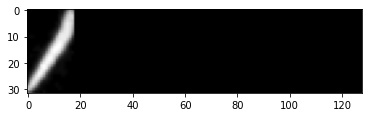



original_text =   ministers
predicted text = mimisters

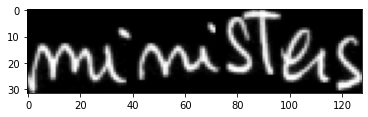



original_text =   against
predicted text = againgt

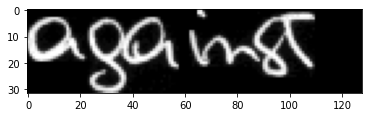



original_text =   have
predicted text = have

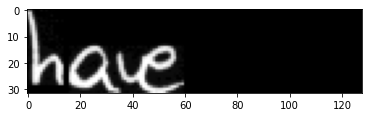



original_text =   is
predicted text = is

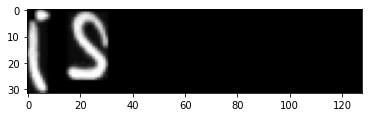



original_text =   .
predicted text = .

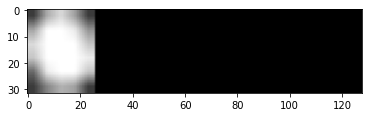



original_text =   is
predicted text = is

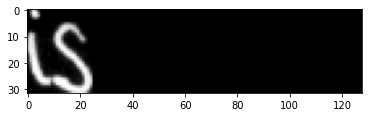



original_text =   by
predicted text = by

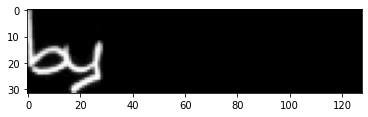



original_text =   Treasury
predicted text = Treasury

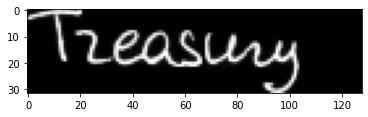



original_text =   It
predicted text = at

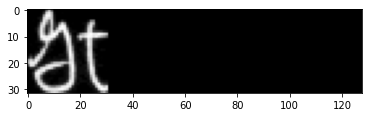



original_text =   to
predicted text = to

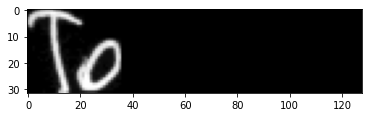



original_text =   business
predicted text = business

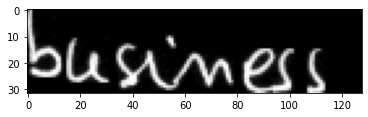



original_text =   .
predicted text = .

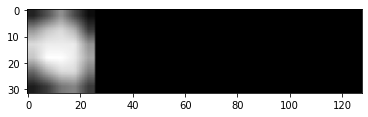



original_text =   BERTRAND
predicted text = BERTRAND

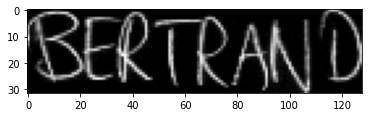



original_text =   the-Bomb
predicted text = the-Brubs

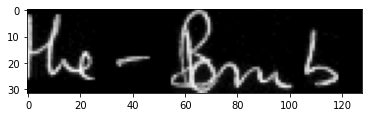



original_text =   him
predicted text = himn

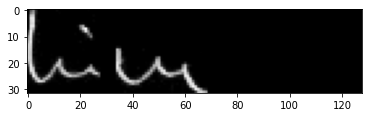

In [ ]:
i=1600
j=1650
prediction = act_model.predict(valid_images[i:j])
 
# use CTC decoder
decoded = K.ctc_decode(prediction,   
                       input_length=np.ones(prediction.shape[0]) * prediction.shape[1],
                       greedy=True)[0][0]

out = K.get_value(decoded)

# see the results
for _, x in enumerate(out):
    
    print("original_text =  ", valid_original_text[i])
    print("predicted text = ", end = '')
    for p in x:
        if int(p) != -1:
            print(char_list[int(p)], end = '')
    plt.imshow(valid_images[i].reshape(32,128), cmap=plt.cm.gray)
    plt.show()
    i+=1
    print('\n')

In [ ]:
def plotgraph(epochs, acc, val_acc):
    # Plot training & validation accuracy values
    plt.plot(epochs, acc, 'b')
    plt.plot(epochs, val_acc, 'r')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy'] 
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,len(loss)+1)

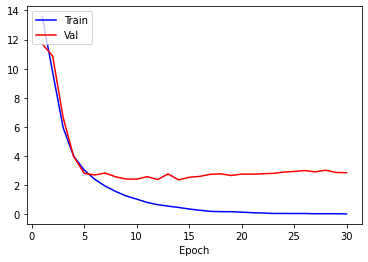

In [ ]:
plotgraph(epochs, loss, val_loss)

In [ ]:
minimum_val_loss = np.min(history.history['val_loss'])
best_model_index = np.where(history.history['val_loss'] == minimum_val_loss)[0][0]

best_loss = str(history.history['loss'][best_model_index])
best_acc = str(history.history['accuracy'][best_model_index])
best_val_loss = str(history.history['val_loss'][best_model_index]) 
best_val_acc = str(history.history['val_accuracy'][best_model_index])

In [ ]:
print(best_loss)
print(best_acc)
print(best_val_acc)

0.4813622236251831
0.8039725422859192
0.6228201389312744
